In [260]:
from matplotlib import animation, rc, pyplot as plt
import pickle
import os
import sys
import shutil
import pandas as pd
import numpy as np
import math
import cv2
import copy
import networkx as nx
import grakel
import netlsd

from scipy.spatial.distance import pdist
from scipy import signal
from sklearn.metrics import homogeneity_score, completeness_score, v_measure_score, accuracy_score, make_scorer, r2_score
from sklearn.datasets import make_blobs, make_circles, make_moons
from sklearn.model_selection import cross_val_score
from sklearn.multioutput import RegressorMixin, RegressorChain
from sklearn.linear_model import Ridge
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
from sklearn.preprocessing import normalize, StandardScaler, MinMaxScaler, RobustScaler
from sklearn.cluster import SpectralClustering, SpectralBiclustering, SpectralCoclustering, KMeans, DBSCAN, OPTICS
from sklearn.decomposition import PCA
from numba import cuda, jit, njit, prange, vectorize

from collections import defaultdict, Counter
from itertools import combinations, product

from multiprocessing import cpu_count
from joblib import Parallel, delayed, pool
from IPython.display import clear_output, HTML
from IPython.core.debugger import set_trace
import torch
from tqdm import tqdm_notebook
from utils import calc_spike_similarity_cuda, place_field_correlation
from graph_metrics import laplacian_keigv_similarity, l2_distance, compute_norm_laplacian_eig, get_first_k_eig
N_CPU = cpu_count()
TOY_DATASET = False

In [261]:
sys.path.append('../network-portrait-divergence/')

In [ ]:
from portrait_divergence import portrait_divergence
 
portrait_divergence(ERi, ERj)

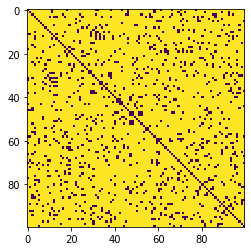

In [278]:
plt.imshow(nx.to_numpy_array(ERi))

# Create data

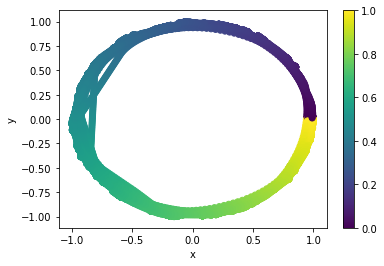

In [57]:
track = 'Circle'
mouse = 25
day = 1
calcium_df = pd.read_csv(f"./data/{track}/data/CA1_{mouse}_{day}D_initial_data.csv", index_col=0)
spikes_df = pd.read_csv(f"./data/{track}/spikes/CA1_{mouse}_{day}D_initial_data_spikes.csv", index_col=0)
rears_events = pd.read_csv(f'./data/CA1_22-25_rears/CA1_{mouse}_{day}D_rears_from_npz.csv', index_col=0)

trim0 = 100
trim1 = 1000
cadata = calcium_df.iloc[:,7:][trim0:-trim1].T.values # [n_neurons, T] 
spdata = spikes_df.iloc[:,1:][trim0:-trim1].T.values # [n_neurons, T]
rears_events = rears_events[trim0:-trim1]

rear_times = rears_events['time_s'].values
rears_indicators = rears_events['rear_1_outward_-1_inward'].values

cells_with_spikes = np.sum(spdata, axis = 1) > 1.

spdata = spdata[cells_with_spikes]
cadata = cadata[cells_with_spikes]
spdata_bool = spdata.astype(bool)

N, T = spdata.shape

# scaler = MinMaxScaler()
# spdata = scaler.fit_transform(spdata)
# cadata = scaler.fit_transform(cadata)

coords = calcium_df[['x','y']][trim0:-trim1].values
coords -= coords.mean(0)[None,:]
minmax_scaler = MinMaxScaler((-1,1))
coords_ = minmax_scaler.fit_transform(coords)

phi = np.arctan2(coords_[:,1], coords_[:,0])
phi[phi < 0] = 2*np.pi + phi[phi < 0]

# # speed sign
dphi = np.diff(phi, prepend=phi[0])
jump_mask = np.abs(dphi) > 6 # jump through breakpoint
dphi[jump_mask] = -1 * np.sign(dphi[jump_mask]) * np.abs(dphi[jump_mask] - 2*np.pi)
circle_sign = np.sign(dphi)

# speed
shift = np.diff(coords_, prepend=[coords_[0]], axis=0)
speed = np.sqrt((shift**2).sum(1)) * circle_sign

# acceleration
acceleration = np.diff(speed, prepend=speed[0])

acceleration_ = MinMaxScaler((0,1)).fit_transform(acceleration[:,None]).flatten()
speed_ = MinMaxScaler((-1,1)).fit_transform(speed[:,None]).flatten()

targets = {
    'x': coords_[:,0],
    'y': coords_[:,1],
    'v': speed_,
    'a': acceleration_,
    'phi': phi
}

rears_indicators_abs = np.pad(np.abs(rears_indicators), pad_width=(T - rears_indicators.shape[0])//2)
phi_ = MinMaxScaler().fit_transform(phi[:,None]).flatten()

plt.scatter(coords_[:,0], coords_[:,1], c=phi_)
plt.xlabel('x')
plt.ylabel('y')
plt.colorbar()
plt.show()

# Create toy dataset

In [58]:
# TOY_DATASET = True

# toy_steps_per_round = 1000
# dphi = 2*np.pi/toy_steps_per_round
# toy_neurons_per_place = 10
# toy_n_places = 4
# toy_timesteps = 5000
# toy_spdata = np.zeros((toy_n_places*toy_neurons_per_place, toy_timesteps))
# toy_phi = []

# for i in range(toy_timesteps):
#     j = i%(toy_steps_per_round) # index within round 
#     step = dphi*j
#     toy_phi.append(step)
#     # number of place
#     k = int(j//(toy_steps_per_round//toy_n_places))
    
#     if i%25==0 and j%(toy_steps_per_round//toy_n_places) != 0:
#         for m,random_offset in enumerate(np.random.choice(np.arange(-3,4), size=toy_neurons_per_place)):
#             toy_spdata[min(toy_neurons_per_place*toy_n_places - 1, (k*toy_neurons_per_place)+m),
#                        i+random_offset] = 1.
    
# toy_phi = np.array(toy_phi) #- np.pi
# x_toy = np.cos(toy_phi)
# y_toy = np.sin(toy_phi)

# plt.figure()
# plt.scatter(x_toy, y_toy, c=toy_phi)
# plt.show()

In [59]:
if TOY_DATASET:
    spdata = toy_spdata
    phi = toy_phi
    coords_ = np.stack([x_toy, y_toy],1)
    spdata_bool = toy_spdata.astype(bool)
    N, T = spdata.shape

In [60]:
print(TOY_DATASET)

False


# Set hyperparameters 

In [73]:
dt = 100
kernel_size=49
start,end = 0, T-dt
SYGMA = 7
kernel_type = 'gaussian'
T_RISE = 10
T_OFF = 40
bins=25

WITH_DIAG=True
REMAKE_CORR = True
REMAKE_PF = True
SELECT_NEURONS = True
ACTIVITY_SELECTIVE_THRESHOLD = 0.001
selective_cells = np.arange(N)[spdata_bool.sum(1) / T > ACTIVITY_SELECTIVE_THRESHOLD]

if not SELECT_NEURONS:
    neurons_selected = np.arange(spdata.shape[0])
else:
    neurons_selected = selective_cells

In [74]:
len(selective_cells)/spdata.shape[0]

0.5583756345177665

In [78]:
if kernel_type == 'gaussian':
    assert kernel_size%2==1
    if SYGMA is None:
        SYGMA = kernel_size//7
    sp = signal.gaussian(M=kernel_size, std=SYGMA)

elif kernel_type == 'exponential':
    def spike_form(t):
        return (1-np.exp(-t/T_RISE))*np.exp(-t/T_OFF)
    x = np.linspace(0, kernel_size, num = kernel_size)
    sp = spike_form(x)[::-1].copy()

sp_torch = torch.tensor(sp).float().cuda()
sp_torch_batch = sp_torch.unsqueeze(0).unsqueeze(0)
spdata_torch = torch.tensor(spdata).float().cuda()

In [79]:
sp_torch.shape

torch.Size([49])

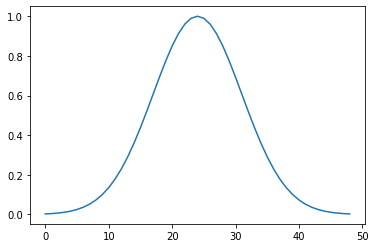

In [80]:
plt.plot(sp)

In [81]:
name = 'TOY' if TOY_DATASET else f'Circle_M{mouse}_D{day}' + ('_diag' if WITH_DIAG else '') + \
        (f'_AT:{ACTIVITY_SELECTIVE_THRESHOLD}' if ACTIVITY_SELECTIVE_THRESHOLD is not None and SELECT_NEURONS else '')

if kernel_type == 'exponential':
    corr_dir = f'./corrmap_data_ext/corrmaps_' + name +  f'_dt0{dt}_kernel{kernel_size}_{kernel_type}_TRISE{T_RISE}_TOFF{T_OFF}'
    
elif kernel_type == 'gaussian':
    corr_dir = f'./corrmap_data_ext/corrmaps_' + name + f'_dt0{dt}_kernel{kernel_size}_{kernel_type}_SYGMA{SYGMA}' 

if os.path.exists(corr_dir):
        if REMAKE_CORR:
            print('Removing corr_dir?')
            answer = input()
            if answer == 'yes':
                shutil.rmtree(corr_dir)
                os.makedirs(corr_dir, exist_ok=True)
else:
    os.makedirs(corr_dir)

In [82]:
pf_dir = f'./pf_data_ext/pf_' + name + f'_dt{dt}_hist2d-bins{bins}' 

if os.path.exists(pf_dir):
        if REMAKE_PF:
            print('Removing pf_dir?')
            answer = input()
            if answer == 'yes':
                shutil.rmtree(pf_dir)
                os.makedirs(pf_dir, exist_ok=True)
else:
    os.makedirs(pf_dir)

# Correlation graphs

In [ ]:
if REMAKE_CORR:
    sim_matrices = Parallel(n_jobs=20, verbose=1)(delayed(calc_spike_similarity_cuda)(sp_torch_batch,
                                                                                     spdata_torch[:,0:i+dt], 
                                                                                     save=True,
                                                                                     corr_dir=corr_dir,
                                                                                     i=i,
                                                                                     with_diag=WITH_DIAG) for i in tqdm_notebook(range(start,end)))
    clear_output()

/media/hpc2_storage/ibulygin/miniconda3/envs/fresh/lib/python3.7/site-packages/ipykernel_launcher.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  import sys


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    6.7s
[Parallel(n_jobs=20)]: Done 160 tasks      | elapsed:   13.6s
[Parallel(n_jobs=20)]: Done 410 tasks      | elapsed:   26.7s
[Parallel(n_jobs=20)]: Done 760 tasks      | elapsed:   45.0s
[Parallel(n_jobs=20)]: Done 1210 tasks      | elapsed:  1.2min
[Parallel(n_jobs=20)]: Done 1760 tasks      | elapsed:  1.6min
[Parallel(n_jobs=20)]: Done 2410 tasks      | elapsed:  2.2min
[Parallel(n_jobs=20)]: Done 3160 tasks      | elapsed:  2.8min
[Parallel(n_jobs=20)]: Done 4010 tasks      | elapsed:  3.6min


[Parallel(n_jobs=20)]: Done 4960 tasks      | elapsed:  4.4min
[Parallel(n_jobs=20)]: Done 6010 tasks      | elapsed:  5.3min
[Parallel(n_jobs=20)]: Done 7160 tasks      | elapsed:  6.2min


In [86]:
corr_paths = np.array([os.path.join(corr_dir, path) for path in sorted(os.listdir(corr_dir), key=lambda x: int(x.split('.')[0]))])

# Place-field graphs

In [90]:
if REMAKE_PF:
    pf_paths = Parallel(n_jobs=10, verbose=1)(delayed(place_field_correlation)(spdata_bool[:,0:i+dt], 
                                                                              coords_[0:i+dt,:],
                                                                              save=True,
                                                                              pf_dir=pf_dir,
                                                                              i=i,
                                                                              bins=bins,
                                                                              with_diag=WITH_DIAG) for i in tqdm_notebook(range(start,end)))
    clear_output()

/media/hpc2_storage/ibulygin/miniconda3/envs/fresh/lib/python3.7/site-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    2.4s
[Parallel(n_jobs=10)]: Done 500 tasks      | elapsed:    5.0s
[Parallel(n_jobs=10)]: Done 1500 tasks      | elapsed:   13.9s
[Parallel(n_jobs=10)]: Done 2900 tasks      | elapsed:   28.6s
[Parallel(n_jobs=10)]: Done 4700 tasks      | elapsed:   50.2s
[Parallel(n_jobs=10)]: Done 6900 tasks      | elapsed:  1.3min
[Parallel(n_jobs=10)]: Done 9500 tasks      | elapsed:  1.8min
[Parallel(n_jobs=10)]: Done 12500 tasks      | elapsed:  2.4min
[Parallel(n_jobs=10)]: Done 15900 tasks      | elapsed:  3.1min


PicklingError: Could not pickle the task to send it to the workers.

In [92]:
pf_paths = np.array([os.path.join(pf_dir, path) for path in sorted(os.listdir(pf_dir), key=lambda x: int(x.split('.')[0]))])

In [93]:
len(corr_paths), len(pf_paths)

(14590, 19140)

# Visualize

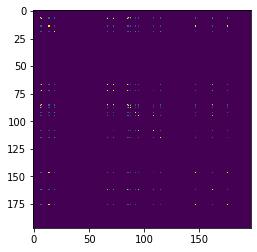

In [96]:
S_last = np.load(corr_paths[0])
plt.imshow(S_last)

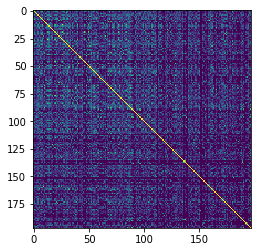

In [144]:
P_last = np.load(pf_paths[-1])
plt.imshow(P_last)

может как-то почистить нейроны? убрать шумные или малоактивные

# Calculate metrics

In [98]:
graph_variance_kernel_size=dt*2

In [99]:
from graph_metrics import laplacian_keigv_similarity

In [100]:
def laplacian_keigv_similarity(p1, p2, neurons_selected=None, return_nonsingle=True, k=15):
    
    if isinstance(p1,str):
        A1 = np.load(p1)
        A2 = np.load(p2)
    else:
        A1=p1
        A2=p2
        
    if neurons_selected is not None:
        A1 = A1[neurons_selected][:,neurons_selected]
        A2 = A2[neurons_selected][:,neurons_selected]
    
    N = A1.shape[0]
    non_single_nodes = np.arange(N)[(A1.sum(0)>0)*(A2.sum(0)>0)]

    if len(non_single_nodes) >= 5:

        A1_n = A1[non_single_nodes][:,non_single_nodes]
        A2_n = A2[non_single_nodes][:,non_single_nodes]
        
        d1 = compute_norm_laplacian_eig(A1_n)
        d2 = compute_norm_laplacian_eig(A2_n)

        v1 = get_first_k_eig(*d1, k=k)
        v2 = get_first_k_eig(*d2, k=k)
        
        n = v1.shape[0]
        d = np.linalg.norm((np.ones((n,n)) - v1@v1.T)@v2@v2.T)
#         d = 1-(np.linalg.norm(v1 - v2, axis=0).mean()/2)

        return [d, non_single_nodes] if return_nonsingle else d
    else:
        return [0, non_single_nodes] if return_nonsingle else 0


In [101]:
A_s = Parallel(n_jobs=-1)(delayed(np.load)(p) for p in tqdm_notebook(corr_paths))
A_s = np.stack(A_s, 0)

/media/hpc2_storage/ibulygin/miniconda3/envs/fresh/lib/python3.7/site-packages/ipykernel_launcher.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """Entry point for launching an IPython kernel.


In [120]:
def l2_distance(p1,p2, neurons_selected=None, use_nonsinge_nodes=False):
    
    if isinstance(p1,str):
        s = np.load(p1)
        p = np.load(p2)
    else:
        s=p1
        p=p2
    
    if neurons_selected is not None:
        s = s[neurons_selected][:,neurons_selected]
        p = p[neurons_selected][:,neurons_selected]

    N = s.shape[0]
    non_single_nodes = np.arange(N)
    if use_nonsinge_nodes:
        non_single_nodes = non_single_nodes[(s.sum(0)>0)*(p.sum(0)>0)]
        
    if len(non_single_nodes) >= 2:
        s = s[non_single_nodes][:,non_single_nodes]
        p = p[non_single_nodes][:,non_single_nodes]
    
        m = np.linalg.norm(s - p) / N**2
    else:
        m = np.nan
    return m

In [250]:
def laplacian_keigv_similarity(p1, p2, neurons_selected=None, return_nonsingle=True, normalize=False, k=10):
    
    if isinstance(p1,str):
        A1 = np.load(p1)
        A2 = np.load(p2)
    else:
        A1=p1
        A2=p2
    
#     set_trace()
    
    if A1.ndim == 1:
        dim = A1.shape[0]
        dim = int(np.sqrt(dim))
        A1 = A1.reshape(dim,dim)
        A2 = A2.reshape(dim,dim)
#         assert np.all(A1.T==A1)
    
    if neurons_selected is not None:
        A1 = A1[neurons_selected][:,neurons_selected]
        A2 = A2[neurons_selected][:,neurons_selected]
    
    N = A1.shape[0]
    non_single_nodes = np.arange(N)[(A1.sum(0)>0)*(A2.sum(0)>0)]
    

    if len(non_single_nodes) >= 5:

        A1_n = A1[non_single_nodes][:,non_single_nodes]
        A2_n = A2[non_single_nodes][:,non_single_nodes]
        
        w1,_ = compute_norm_laplacian_eig(A1_n)
        w2,_ = compute_norm_laplacian_eig(A2_n)
        
        d = np.linalg.norm(w1[:k]-w2[:k])
        
        percentage = N/len(non_single_nodes)
        
        if normalize:
            d *= percentage

        return (d, non_single_nodes) if return_nonsingle else d
    else:
        return (0, non_single_nodes) if return_nonsingle else 0

In [251]:
# @jit
def graphs_variance(A_s, metric):
    l = A_s.shape[0]
    A_s_flatten = A_s.reshape((l,-1))
    D = pdist(A_s_flatten, metric=metric)
#     l = len(A_s)
#     D = np.zeros((l,l))
#     for i in range(l):
#         for j in range(i+1,l):
#             d_ij = metric(A_s[i], A_s[j])
#             D[i,j] = d_ij 
#             D[j,i] = d_ij 
    return D

In [252]:
# metric = lambda p1,p2: l2_distance(p1, p2, neurons_selected=None, use_nonsinge_nodes=False)

# D_s = []
# for i in tqdm_notebook(range(len(A_s) - graph_variance_kernel_size)): 
#     D_s.append(graphs_variance(A_s[i:i+graph_variance_kernel_size], metric=metric))

In [ ]:
metric = lambda p1,p2: laplacian_keigv_similarity(p1, p2, neurons_selected=neurons_selected, return_nonsingle=False, normalize=True, k=10)
D_ws = []
for i in tqdm_notebook(range(len(A_s) - graph_variance_kernel_size)): 
    D_ws.append(graphs_variance(A_s[i:i+graph_variance_kernel_size], metric=metric))


/media/hpc2_storage/ibulygin/miniconda3/envs/fresh/lib/python3.7/site-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
np.save(f'./D_s_data_ext/D_s_k{graph_variance_kernel_size}_W10_l2-diag-nonsingle-norm_neurons_selected-act_trh{ACTIVITY_SELECTIVE_THRESHOLD}', D_ws)

Text(0, 0.5, 'L2 norm')

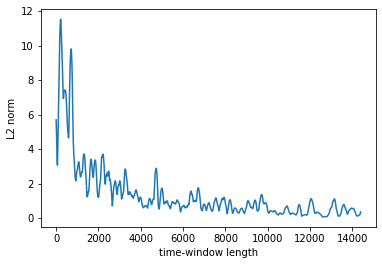

In [109]:
plt.plot(D_s.mean(-1))
plt.xlabel('time-window length')
plt.ylabel('L2 norm')